In [12]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import List
import datetime
from langchain.output_parsers import PydanticToolsParser
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
import json
from typing import List, Dict, Any
from langchain_community.tools import TavilySearchResults
from langgraph.graph import END, MessageGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from pprint import pprint


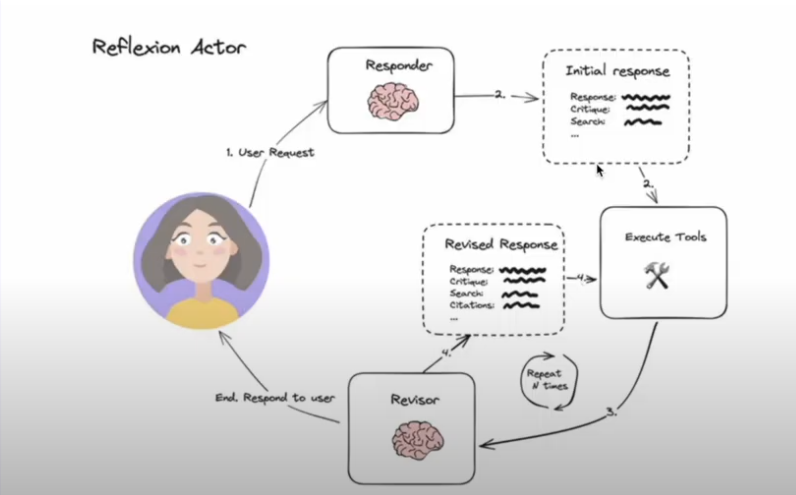

In [2]:
load_dotenv()

True

In [3]:
llmOpenAI=ChatOpenAI(model="gpt-3.5-turbo",temperature=0.5)
llmGemini=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

<h3>Defining the Chat Prompt Template</h3>

In [4]:
actorPromptTemplate=ChatPromptTemplate.from_messages(messages=[
    (
        "system",
         """
             You are an expert AI researcher
             Current time: {time}
             
             1. {first_instruction}
             2. Reflect and critique your answer. Be severe to maximize improvement.
             3. After the reflection, **list 1-3 search queries separately** for researching improvements. 
             Do not include them inside the reflection
         """
    ),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system",
        "Answer the user's question above using the required format")
    ]
).partial(
            time=lambda: datetime.datetime.now().isoformat()
         )

<h3>Function Calling with Pydantic Schema</h3>

In [5]:
class Reflection(BaseModel):
    missing: str=Field(description="Critique of what is missing.")
    superflous: str=Field(description="Critique of what is superflous")

In [6]:
class AnswerQuestion(BaseModel):
    """
        Answer the question
    """
    answer: str=Field(description="~250 word detailed answer to the question")
    search_queries:List[str]=Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer"
    )
    reflection:Reflection=Field(description="Your reflection on the initial answer")

In [7]:
firstResponderPromptTemplate=actorPromptTemplate.partial(
    first_instruction="Provide a detailed ~250 word answer"
)

In [8]:
pydanticParser=PydanticToolsParser(tools=[AnswerQuestion])

In [9]:
firstResponderChain=firstResponderPromptTemplate | llmGemini.bind_tools(
                                                        tools=[AnswerQuestion],
                                                        tool_choice="AnswerQuestion"  # the first choice of tool
                                                        )

In [10]:
# illutrations
firstResponderResponse=firstResponderChain.invoke(input={
    "messages": [HumanMessage(content="Write me a blog post on how small business can leverage AI to grow")]
})

In [13]:
# illutrations
pprint(firstResponderResponse.model_dump())

{'additional_kwargs': {'function_call': {'arguments': '{"reflection": '
                                                      '{"superflous": "The '
                                                      'introduction is a bit '
                                                      'generic and could be '
                                                      'more engaging. The '
                                                      'phrase \\"level the '
                                                      'playing field\\" is a '
                                                      'bit clich\\u00e9.", '
                                                      '"missing": "The blog '
                                                      'post lacks specific '
                                                      'examples of AI tools '
                                                      'and platforms that '
                                                      'small businesses can 

<h3>Revisor Section</h3>

In [14]:
reviseInstructions="""
Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer
    - You must include numerical citations in your revised answer to ensure it can be verified
    - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
        - [1] https://example.com
        - [2] https://example.com
    - You should use the previous critique to remove superflous information from your answer and make SURE it is not more than 250 words
"""

In [15]:
revisorPromptTemplate=actorPromptTemplate.partial(first_instruction=reviseInstructions)

In [16]:
class ReviseAnswer(AnswerQuestion):  # inheriting the AnswerQuestion class
    """
    Revise your original answer to your question
    """
    references:List[str]=Field(description="Citations motivating your updated answer")

In [17]:
revisorChain=revisorPromptTemplate | llmGemini.bind_tools(
                                    tools=[ReviseAnswer],
                                    tool_choice="ReviseAnswer"
                                            ) 

In [38]:
# illustrations
json.loads(firstResponderResponse.additional_kwargs['function_call']['arguments'])['answer']

'## Small Business, Big Growth: How AI Can Be Your Secret Weapon\n\nFor small business owners, the idea of incorporating Artificial Intelligence (AI) might seem like something reserved for tech giants. However, AI is becoming increasingly accessible and affordable, offering a wealth of opportunities for even the smallest enterprises to boost efficiency, enhance customer experiences, and drive growth. The key is understanding where AI can provide the most impactful solutions.\n\nOne of the most immediate benefits of AI is automation. AI-powered tools can automate repetitive tasks like data entry, invoice processing, and scheduling, freeing up valuable time for business owners and employees to focus on strategic initiatives. Chatbots can provide instant customer support, answering common questions and resolving simple issues 24/7, improving customer satisfaction without requiring additional staff. AI algorithms can analyze sales data to identify trends, predict demand, and optimize inven

In [36]:
# illutrations
revisorResponse=revisorChain.invoke(input={
    # "messages": [HumanMessage(content=firstResponderResponse[0].answer)]
    "messages":[json.loads(firstResponderResponse.additional_kwargs['function_call']['arguments'])['answer']]
})

In [37]:
# illutrations
revisorResponse

AIMessage(content='', additional_kwargs={'function_call': {'name': 'ReviseAnswer', 'arguments': '{"reflection": {"superflous": "The previous answer is fine in length, no need to shorten it", "missing": "The previous answer lacks specific numerical citations to support its claims. It also needs a references section."}, "references": ["https://www.example.com/automation", "https://www.example.com/chatbots", "https://www.example.com/inventory_optimization", "https://www.example.com/personalized_marketing", "https://www.example.com/ai_for_small_business"], "answer": "AI offers significant benefits for small businesses, including automation, enhanced customer experiences, and data-driven insights. Automating tasks like data entry and invoice processing frees up time for strategic initiatives [1]. AI-powered chatbots provide 24/7 customer support, improving satisfaction [2]. AI algorithms analyze sales data to optimize inventory and predict demand, minimizing waste and maximizing profits [3]

<h3>Tool Execution Section</h3>

In [39]:
tavilyTool=TavilySearchResults(max_results=5)

In [41]:
# function to execute search queries from AnswerQuestion tool calls
def execute_tools(state:List[BaseMessage]) -> List[BaseMessage]:
    last_ai_message: AIMessage=state[-1]

    # extract tool calls from the AI Message
    if not hasattr(last_ai_message,"tool_calls") or not last_ai_message.tool_calls:
        return []
    else:
        tool_messages=[]
        for tool_call in last_ai_message.tool_calls:
            if tool_call["name"] in ["ReviseAnswer","AnswerQuestion"]:
                call_id=tool_call["id"]
                search_queries=tool_call["args"].get("search_queries",[])
                # Execute each search query with the tavily tool
                query_results={}
                for query in search_queries:
                    result=tavilyTool.invoke(input=query)
                    query_results[query]=result
                
                tool_messages.append(ToolMessage(
                    content=json.dumps(obj=query_results),
                    tool_call_id=call_id
                    )
                    )

        return tool_messages

In [42]:
# illustrations purpose
test_state = [
    HumanMessage(
        content="Write about how small business can leverage AI to grow"
    ),
    AIMessage(
        content="", 
        tool_calls=[
            {
                "name": "AnswerQuestion",
                "args": {
                    'answer': '', 
                    'search_queries': [
                            'AI tools for small business', 
                            'AI in small business marketing', 
                            'AI automation for small business'
                    ], 
                    'reflection': {
                        'missing': '', 
                        'superfluous': ''
                    }
                },
                "id": "call_KpYHichFFEmLitHFvFhKy1Ra",
            }
        ],
    )
]


In [43]:
# illustrations purpose
results=execute_tools(state=test_state)
results

[ToolMessage(content='{"AI tools for small business": [{"title": "The 20 Best AI Tools for Small Businesses and How to Use Them", "url": "https://blog.hubspot.com/sales/small-business-ai-tools", "content": "To figure out which tools stand out from the hype, I road-tested 20affordable AI tools for small businesses. Here\'s what I found.\\n\\n### 1. HubSpot\\n\\nHubSpot is a CRM platform that can help you simplify your processes across sales, marketing, and customer support. The platform integrates AI recommendations across these areas to help you improve anywhere from inbound marketing campaigns to your business operations. [...] I\'m always interested in new tools that can make running a business more efficient. One such tool is DreamHost\'s AI Business Advisor, designed to offer tailored business insights using artificial intelligence. [...] Aside from ChatGPT and my specific use for it, plenty of other AI tools on the market can help your small business. And I road-tested 20 of them 

In [52]:
pprint(json.loads(results[0].content)['AI automation for small business'])

[{'content': 'AI for small business Women-Owned Small Business Federal '
             'Contract program AI for small business AI for small business AI '
             'for small business Small businesses can use AI tools and '
             'applications to find solutions for all kinds of issues. As a '
             'small business owner, AI can help your small businesses do more '
             'with less. SBA is dedicated to informing small businesses about '
             'the ethical use of AI tools. Read on to find out about both the '
             'benefits and risks of using AI in your small business. How AI '
             'can benefit your small business AI can help your business: AI '
             'can help you analyze your small business data and pick out '
             'common themes. If you work alone, AI can help you collaborate on '
             'business solutions.',
  'score': 0.98583,
  'title': 'AI for small business',
  'url': 'https://www.sba.gov/business-guide/manage-y

In [53]:
isinstance(results[0],ToolMessage)

True

In [54]:
# illustrations purpose
json.loads(results[0].content).keys()

dict_keys(['AI tools for small business', 'AI in small business marketing', 'AI automation for small business'])

In [55]:
# illustrations purpose
json.loads(results[0].content)['AI in small business marketing']

[{'title': 'How to Use AI for Small Business Marketing (With Examples)',
  'url': 'https://www.mailmodo.com/guides/ai-for-small-business-marketing/',
  'content': 'As per the businessdit, the marketers who utilize AI for email personalization are likely to get an increase in the revenue by 41%, and CTR by 13.44% respectively.\n\nSmall businesses can also harness the power of AI tools like Phrasee and generate great marketing messages for delivering across digital customer journeys. You can incorporate a tailor made strategy that suits your target audience by analyzing the customer interactions via email open rates, click-through rates etc. [...] In small business marketing, AI can be used for automated targeting, lead generation/nurturing, content creation, social media management etc. It reduces marketing costs and saves time and resources. Overall, it helps in enhancing customer experience and generating more revenue.\n\n### 3.Do small businesses need technical expertise to implement

<h3>Reflexion Graph</h3>

In [56]:
graph=MessageGraph()

In [57]:
MAX_ITERATIONS=2

In [58]:
graph.add_node(node="draft",action=firstResponderChain)

In [59]:
graph.add_node(node="execute_tools", action=execute_tools)

In [60]:
graph.add_node(node="revisor",action=revisorChain)

In [61]:
graph.add_edge(start_key="draft",end_key="execute_tools")

In [62]:
graph.add_edge(start_key="execute_tools",end_key="revisor")

In [63]:
def event_loop(state:List[BaseMessage]) -> str:
    count_tool_visits=sum(isinstance(item, ToolMessage) for item in state)
    num_iterations=count_tool_visits
    if num_iterations>MAX_ITERATIONS:
        return END
    else:
        return "execute_tools"

In [64]:
graph.add_conditional_edges(source="revisor",path=event_loop)

In [65]:
graph.set_entry_point(key="draft")

In [66]:
app=graph.compile()

In [67]:
print(app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	draft(draft)
	execute_tools(execute_tools)
	revisor(revisor)
	__end__([<p>__end__</p>]):::last
	__start__ --> draft;
	draft --> execute_tools;
	execute_tools --> revisor;
	revisor --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [68]:
app.get_graph().print_ascii()

  +-----------+    
  | __start__ |    
  +-----------+    
        *          
        *          
        *          
    +-------+      
    | draft |      
    +-------+      
        *          
        *          
        *          
+---------------+  
| execute_tools |  
+---------------+  
        *          
        *          
        *          
   +---------+     
   | revisor |     
   +---------+     
        *          
        *          
        *          
   +---------+     
   | __end__ |     
   +---------+     


In [69]:
final_response=app.invoke(input=HumanMessage("Write about how small business can leverage AI to grow?"))

In [70]:
final_response[-1].tool_calls[0]["args"]["answer"]

'Small businesses can leverage AI to foster growth [1]. AI-powered chatbots, like those from Tidio [2], handle routine inquiries, offering instant support and freeing human agents, boosting customer satisfaction and cutting costs. AI personalizes marketing using customer data [1]; tools like ReConvert Upsell & Cross Sell [1] enhance customer experience and sales. AI analytics, such as Google Analytics [4], reveal market trends, enabling data-driven decisions [1]. AI optimizes inventory by predicting demand [1]. Operationally, AI automates data entry and invoicing [1]; Microsoft 365 Copilot [5] aids administrative tasks. Challenges include knowledge gaps (77% lack understanding [3]), system compatibility, and security [3]. Ethical AI means avoiding bias in ads [6]. Training, data quality, and transparency are key [3, 6]. Despite hurdles, AI enhances competitiveness [1]. User-friendly AI is essential [6].'

In [ ]:
final_response

[HumanMessage(content='Write about how small business can leverage AI to grow?', additional_kwargs={}, response_metadata={}, id='d8cd1b66-55e6-4a85-bdb2-1b572550dcd1'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'AnswerQuestion', 'arguments': '{"answer": "Small businesses can leverage AI in numerous ways to foster growth, often without requiring extensive technical expertise or significant upfront investment. One key area is customer service, where AI-powered chatbots can provide instant support, answer frequently asked questions, and resolve basic issues, freeing up human employees to handle more complex inquiries. These chatbots can operate 24/7, improving customer satisfaction and potentially increasing sales. AI can also enhance marketing efforts through personalized recommendations and targeted advertising. By analyzing customer data, AI algorithms can identify patterns and preferences, allowing businesses to create more effective marketing campaigns and i

In [74]:
json.loads(final_response[1].additional_kwargs['function_call']['arguments'])

{'reflection': {'missing': "The answer is quite general and lacks specific examples of AI tools or services that small businesses can readily use. It also doesn't address the challenges small businesses might face in adopting AI, such as data limitations, cost concerns, and lack of technical skills. It could also benefit from discussing ethical considerations related to AI implementation.",
  'superflous': "The answer is concise, and there isn't much that is superfluous. However, the introductory sentence could be slightly more focused."},
 'answer': 'Small businesses can leverage AI in numerous ways to foster growth, often without requiring extensive technical expertise or significant upfront investment. One key area is customer service, where AI-powered chatbots can handle routine inquiries, provide instant support, and free up human agents to address more complex issues. This improves customer satisfaction and reduces operational costs. AI can also personalize marketing efforts by a

In [87]:
json.loads(final_response[2].content).keys()

dict_keys(['AI tools for small business customer service', 'AI-powered marketing solutions for small businesses', 'challenges of AI adoption for small businesses'])

In [88]:
final_response

[HumanMessage(content='Write about how small business can leverage AI to grow?', additional_kwargs={}, response_metadata={}, id='44d70751-d8de-477e-bb25-ab50487252ab'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'AnswerQuestion', 'arguments': '{"reflection": {"missing": "The answer is quite general and lacks specific examples of AI tools or services that small businesses can readily use. It also doesn\'t address the challenges small businesses might face in adopting AI, such as data limitations, cost concerns, and lack of technical skills. It could also benefit from discussing ethical considerations related to AI implementation.", "superflous": "The answer is concise, and there isn\'t much that is superfluous. However, the introductory sentence could be slightly more focused."}, "answer": "Small businesses can leverage AI in numerous ways to foster growth, often without requiring extensive technical expertise or significant upfront investment. One key area is c

In [89]:
len(final_response)

8

In [90]:
final_response[4]

ToolMessage(content='{"AI analytics tools for small business": [{"title": "Ai Tools For Small Business: Boosting Efficiency And Growth - CallRail", "url": "https://www.callrail.com/blog/ai-tools-small-business", "content": "AI-based analytics tools offer powerful solutions for small businesses looking to gain insights from their data. These tools help businesses uncover hidden trends, patterns, and insights that can drive decision-making and improve overall efficiency. By leveraging AI, small businesses can process vast amounts of data at unprecedented speeds, enabling them to identify opportunities and make informed decisions quickly.\\n\\n#### Tableau [...] Tableau is a popular AI-driven business analytics tool that enables users to visualize, explore, and understand their data. It offers _drag-and-drop_ data exploration, real-time collaboration, and _pre-built_ visualizations. Tableau allows small businesses to harness the power of AI to derive meaningful insights from their data, h

In [91]:
final_response[6]

ToolMessage(content='{}', id='45f904db-2314-408f-bdf8-f569b13291e9', tool_call_id='86f1959f-9e83-4aca-9fbe-188887b2f72d')